Aim of this notebook is to look at calibrated stereo images and to visualize some mathematical properties of pairs of matched keypoints, found by opencv sift algorithms or our pysift implementation.


Imports


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "visualize_hessian"))

import visu_hessian as vh

# return to the root directory
sys.path.append(os.path.join(".."))

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "descriptor"))

import descriptor.descriptor as desc

# return to the root directory
sys.path.append(os.path.join(".."))

# Load grayscale image


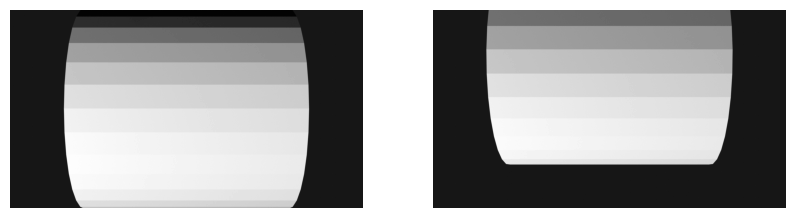

In [2]:
img_folder = "../data/blender"
im_name1 = "cylinder_l"
im_name2 = "cylinder_r"
im_ext = "png"
im1 = cv.imread(f"{img_folder}/{im_name1}.{im_ext}", cv.IMREAD_GRAYSCALE)
im2 = cv.imread(f"{img_folder}/{im_name2}.{im_ext}", cv.IMREAD_GRAYSCALE)

# compute float32 versions for calculations
float_im1 = vh.convert_uint8_to_float32(im1)
float_im2 = vh.convert_uint8_to_float32(im2)

# compute min and max values for normalization
min_val = min(float_im1.min(), float_im2.min())
max_val = max(float_im1.max(), float_im2.max())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(float_im1, cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(float_im2, cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.show()

# Match SIFT Keypoints on stereo setup


In [3]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# print number of keypoints detected in each image
print(f"Number of keypoints detected in {im_name1}: {len(kp1)}")
print(f"Number of keypoints detected in {im_name2}: {len(kp2)}")

Number of keypoints detected in cylinder_l: 16
Number of keypoints detected in cylinder_r: 15


In [4]:
# BFMatcher with default params
# default norm is L2
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
threshold = 0.75
good = []
for m, n in matches:
    if m.distance < threshold * n.distance:
        good.append([m])

# Alternative: crossCheck=True
bf_CC = cv.BFMatcher(crossCheck=True)
matches_CC = bf_CC.match(des1, des2)

# Sort them in the order of their distance.
good_sorted = sorted(good, key=lambda x: x[0].distance)
matches_CC_sorted = sorted(matches_CC, key=lambda x: x.distance)

# print the distances
print("Distances with Lowe's ratio:")
for m in good_sorted[:10]:
    print(f"{m[0].distance:.2f}", end=" ")

print("\nDistances with crossCheck:")
for m in matches_CC_sorted[:10]:
    print(f"{m.distance:.2f}", end=" ")

Distances with Lowe's ratio:
59.23 60.21 64.14 78.12 80.44 111.75 129.97 
Distances with crossCheck:
35.93 59.23 60.21 64.14 155.96 182.72 

In [5]:
# cv.drawMatchesKnn expects list of lists as matches.
nb_matches_to_draw = 100

img3 = cv.drawMatchesKnn(
    im1,
    kp1,
    im2,
    kp2,
    good_sorted[:nb_matches_to_draw],
    outImg=None,
    singlePointColor=(255, 0, 0),
)
img4 = cv.drawMatches(
    im1,
    kp1,
    im2,
    kp2,
    matches_CC_sorted[:nb_matches_to_draw],
    singlePointColor=(255, 0, 0),
    outImg=None,
)

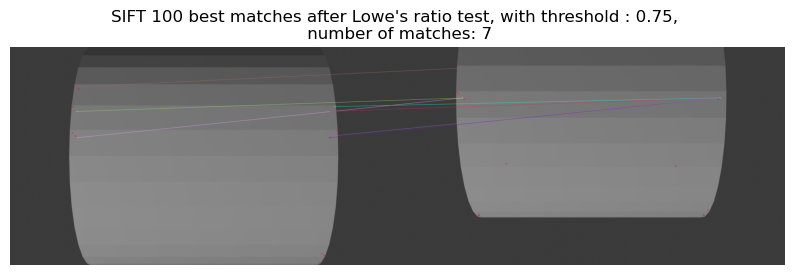

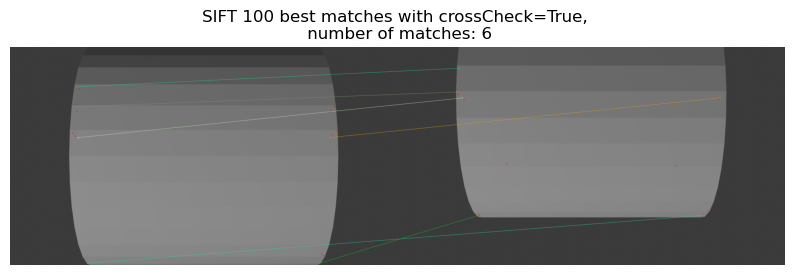

In [6]:
# display matches
plt.figure(figsize=(10, 5))
plt.imshow(img3)
plt.axis("off")
plt.title(
    f"SIFT {nb_matches_to_draw} best matches after Lowe's ratio test, with threshold : {threshold}, \n number of matches: {len(good)}"
)
# save figure
plt.savefig(
    f"{img_folder}/{im_name1}_sift_matches_{nb_matches_to_draw}_lowe.png", dpi=600
)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(img4)
plt.axis("off")
plt.title(
    f"SIFT {nb_matches_to_draw} best matches with crossCheck=True, \n number of matches: {len(matches_CC)}"
)
# save figure
plt.savefig(
    f"{img_folder}/{im_name1}_sift_matches_{nb_matches_to_draw}_crossCheck.png", dpi=600
)
plt.show()

# Visualize gradients and curvatures


In [7]:
# store keypoints of good matches in 2 lists, 1 per image
kp_img1 = []
kp_img2 = []

for m in good_sorted:
    kp_img1.append(kp1[m[0].queryIdx])
    kp_img2.append(kp2[m[0].trainIdx])

# print lengths of lists
print(f"Number of 'good' matched keypoints in {im_name1}: {len(kp_img1)}")
print(f"Number of 'good' matched keypoints in {im_name2}: {len(kp_img2)}")

Number of 'good' matched keypoints in cylinder_l: 7
Number of 'good' matched keypoints in cylinder_r: 7


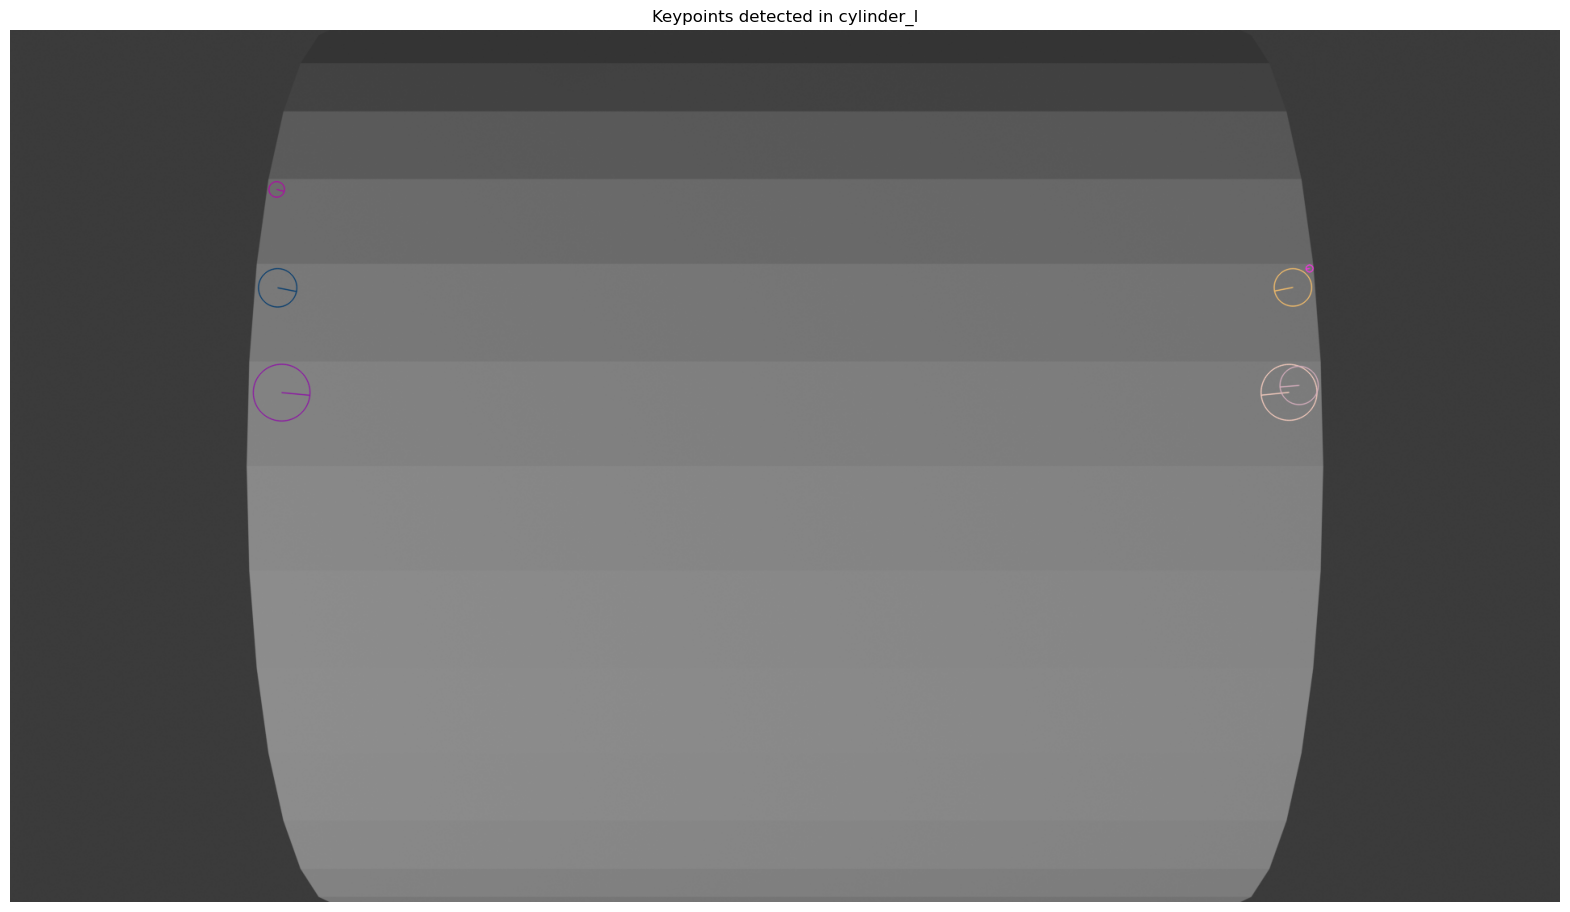

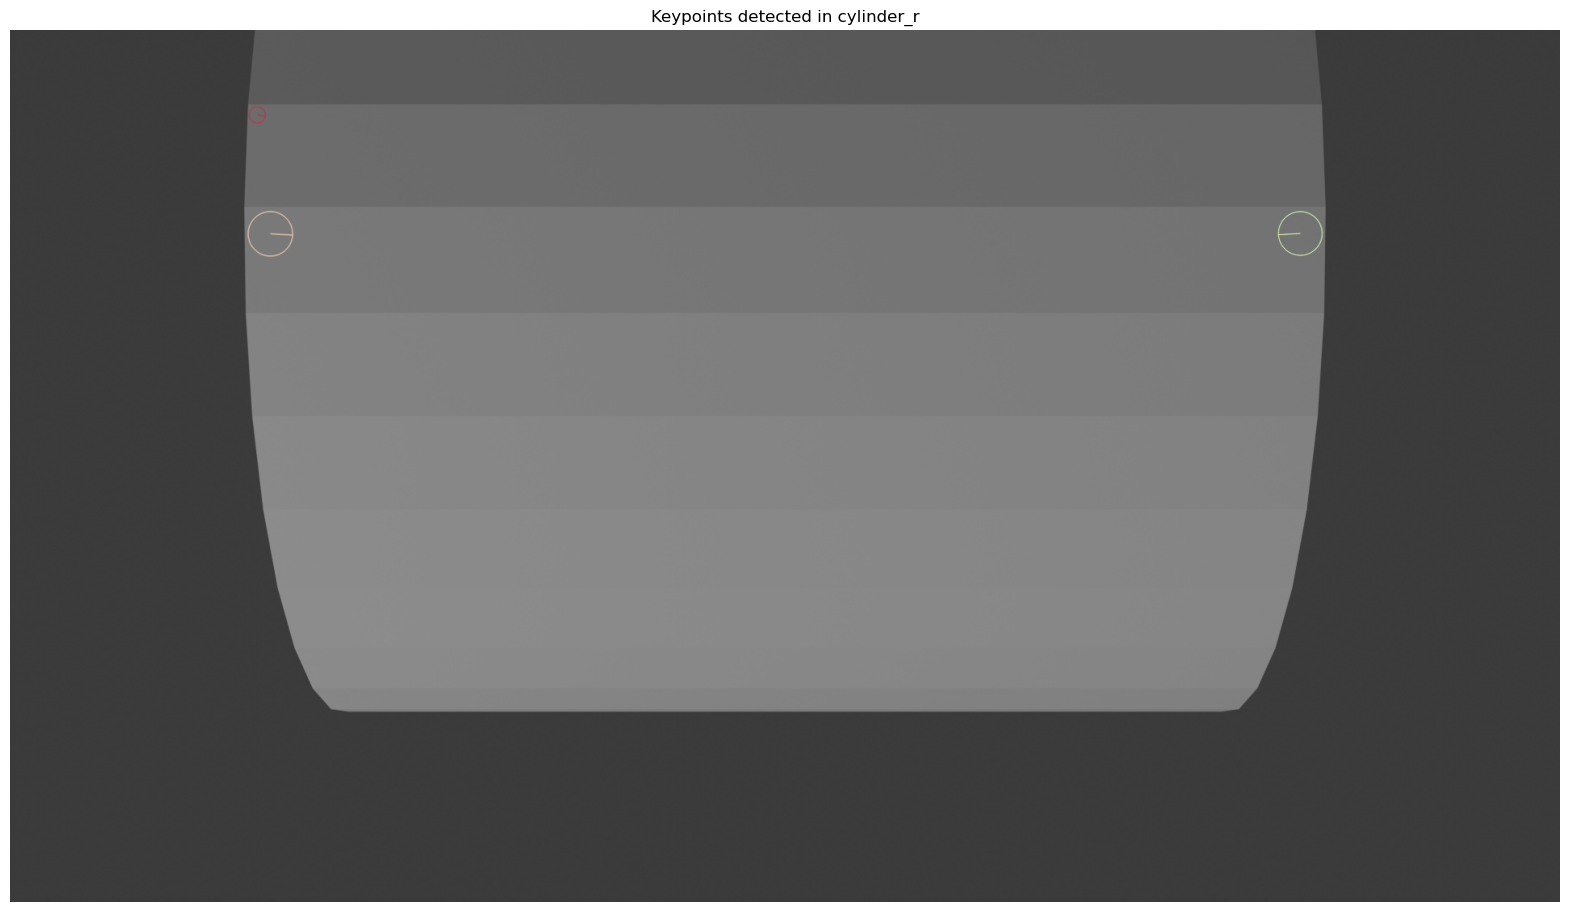

In [8]:
# show image 1 with keypoints
kp_img1_draw = cv.drawKeypoints(
    im1, kp_img1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img1_draw)
plt.axis("off")
plt.title(f"Keypoints detected in {im_name1}")
# save figure
# plt.savefig(f"{img_folder}/cubes_sift_kp1.png", dpi=600)
plt.show()

# show image 2 with keypoints
kp_img2_draw = cv.drawKeypoints(
    im2, kp_img2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img2_draw)
plt.axis("off")
plt.title(f"Keypoints detected in {im_name2}")
# save figure
# plt.savefig(f"{img_folder}/cubes_sift_kp2.png", dpi=600)
plt.show()

Show curvature values


In [17]:
zoom_radius = 50
kp_index = 5
kp1 = kp_img1[kp_index]
kp2 = kp_img2[kp_index]

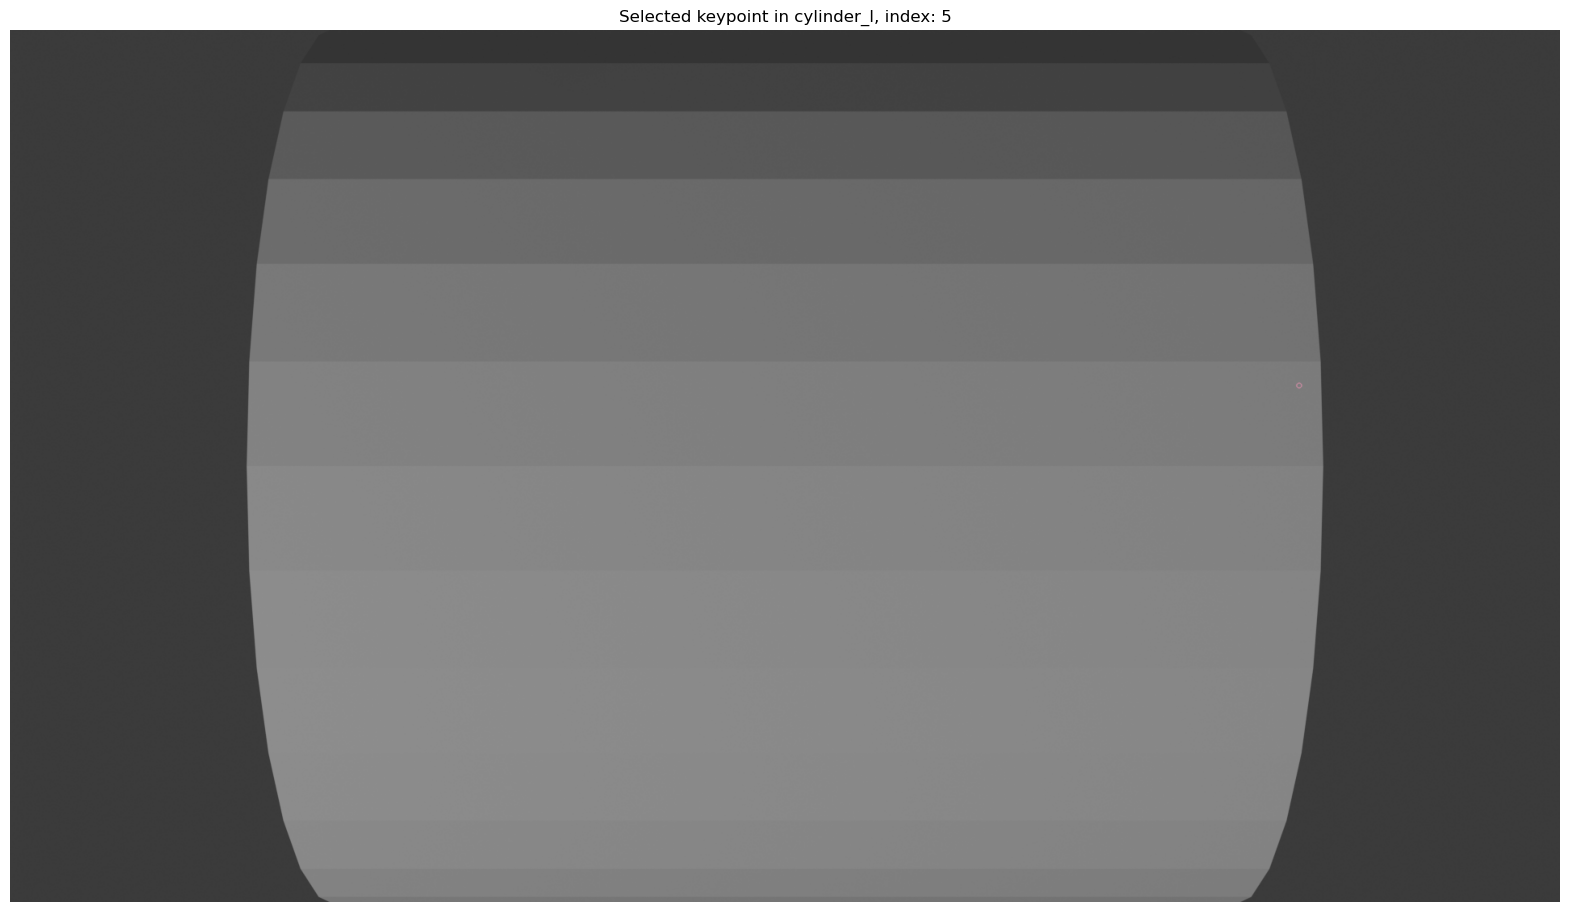

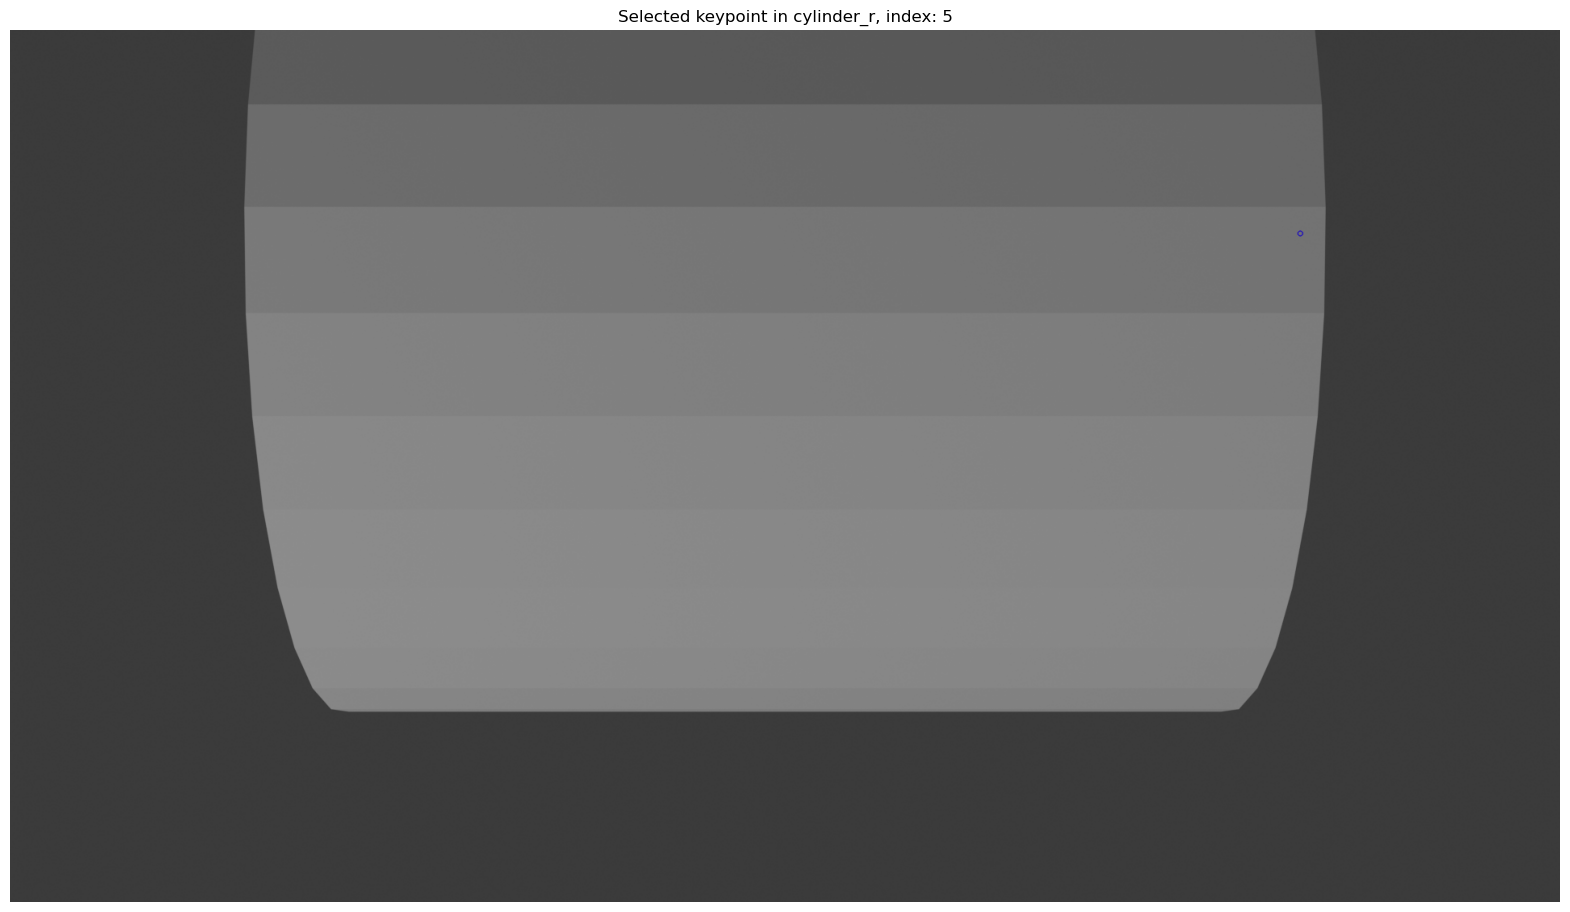

In [18]:
# draw single keypoint on image 0
kp_img1_draw_single = cv.drawKeypoints(im1, [kp1], None, flags=None)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img1_draw_single)
plt.axis("off")
plt.title(f"Selected keypoint in {im_name1}, index: {kp_index}")
# save figure
plt.show()

# draw single keypoint on image 1
kp_img2_draw_single = cv.drawKeypoints(im2, [kp2], None, flags=None)
plt.figure(figsize=(20, 20))
plt.imshow(kp_img2_draw_single)
plt.axis("off")
plt.title(f"Selected keypoint in {im_name2}, index: {kp_index}")
# save figure
plt.show()

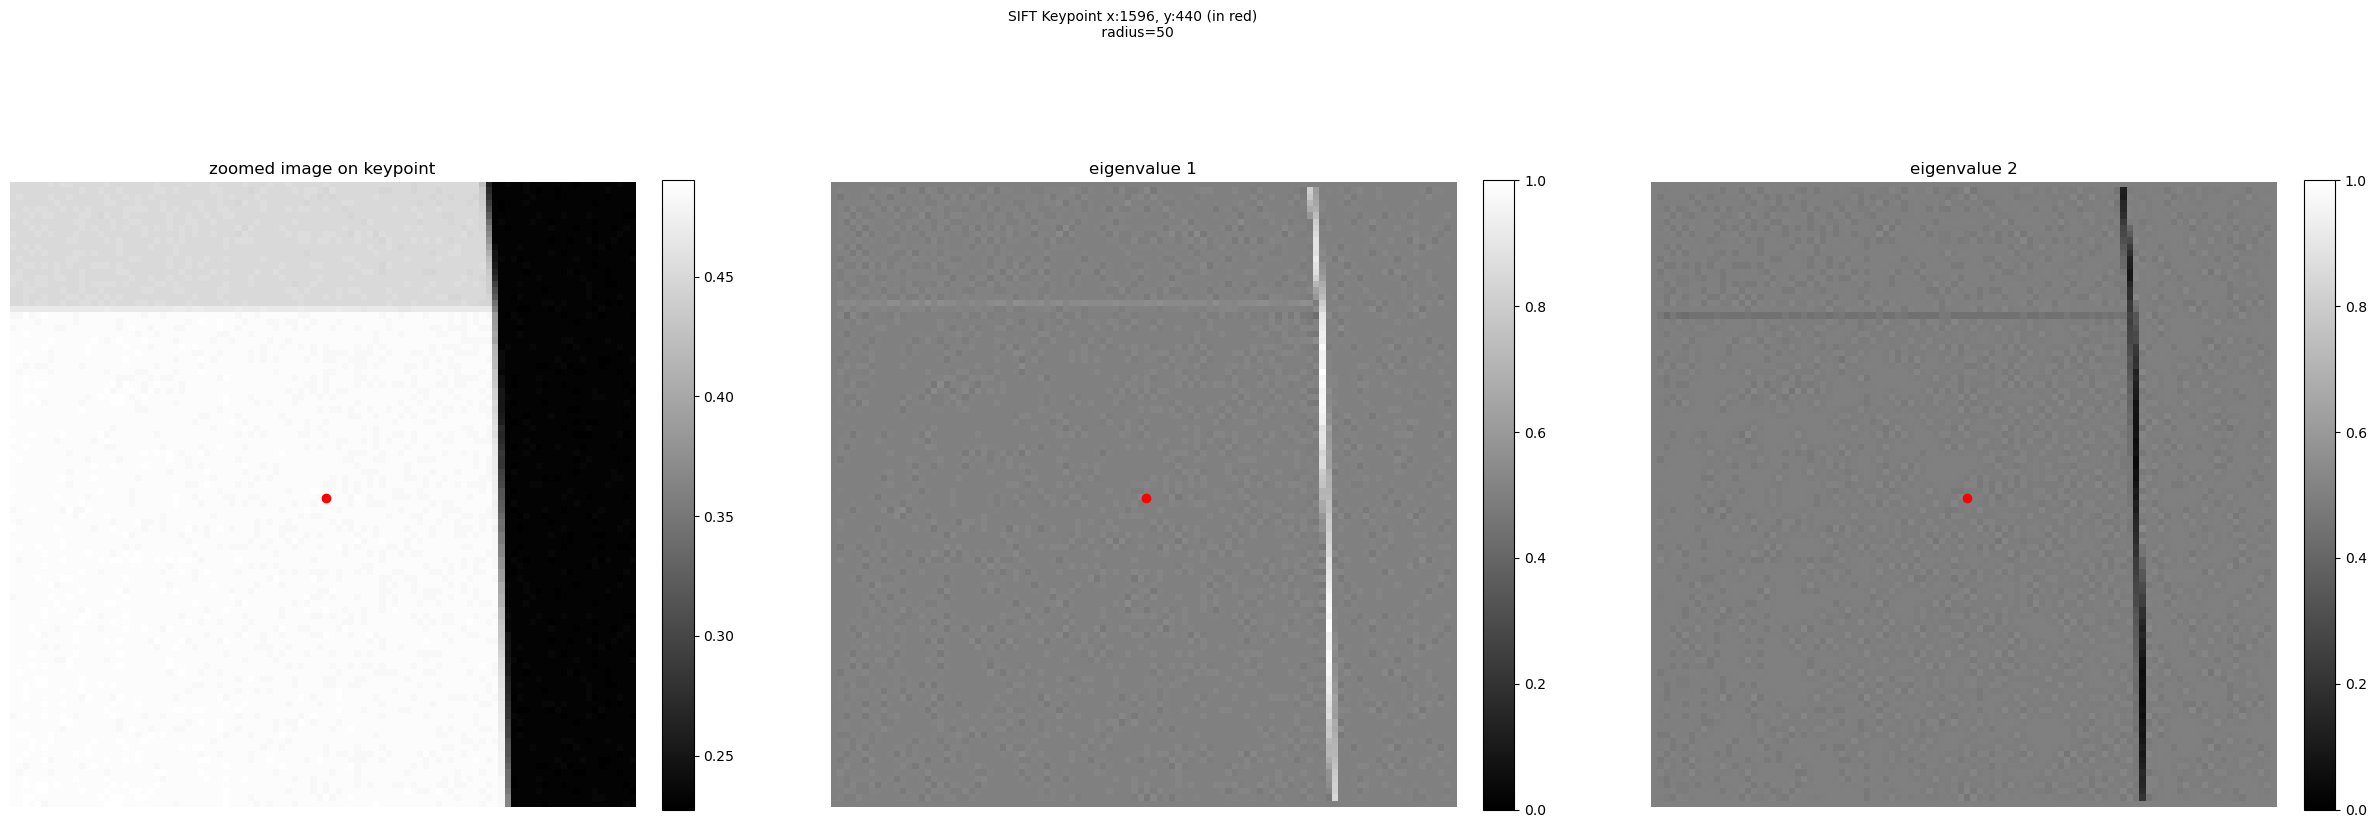

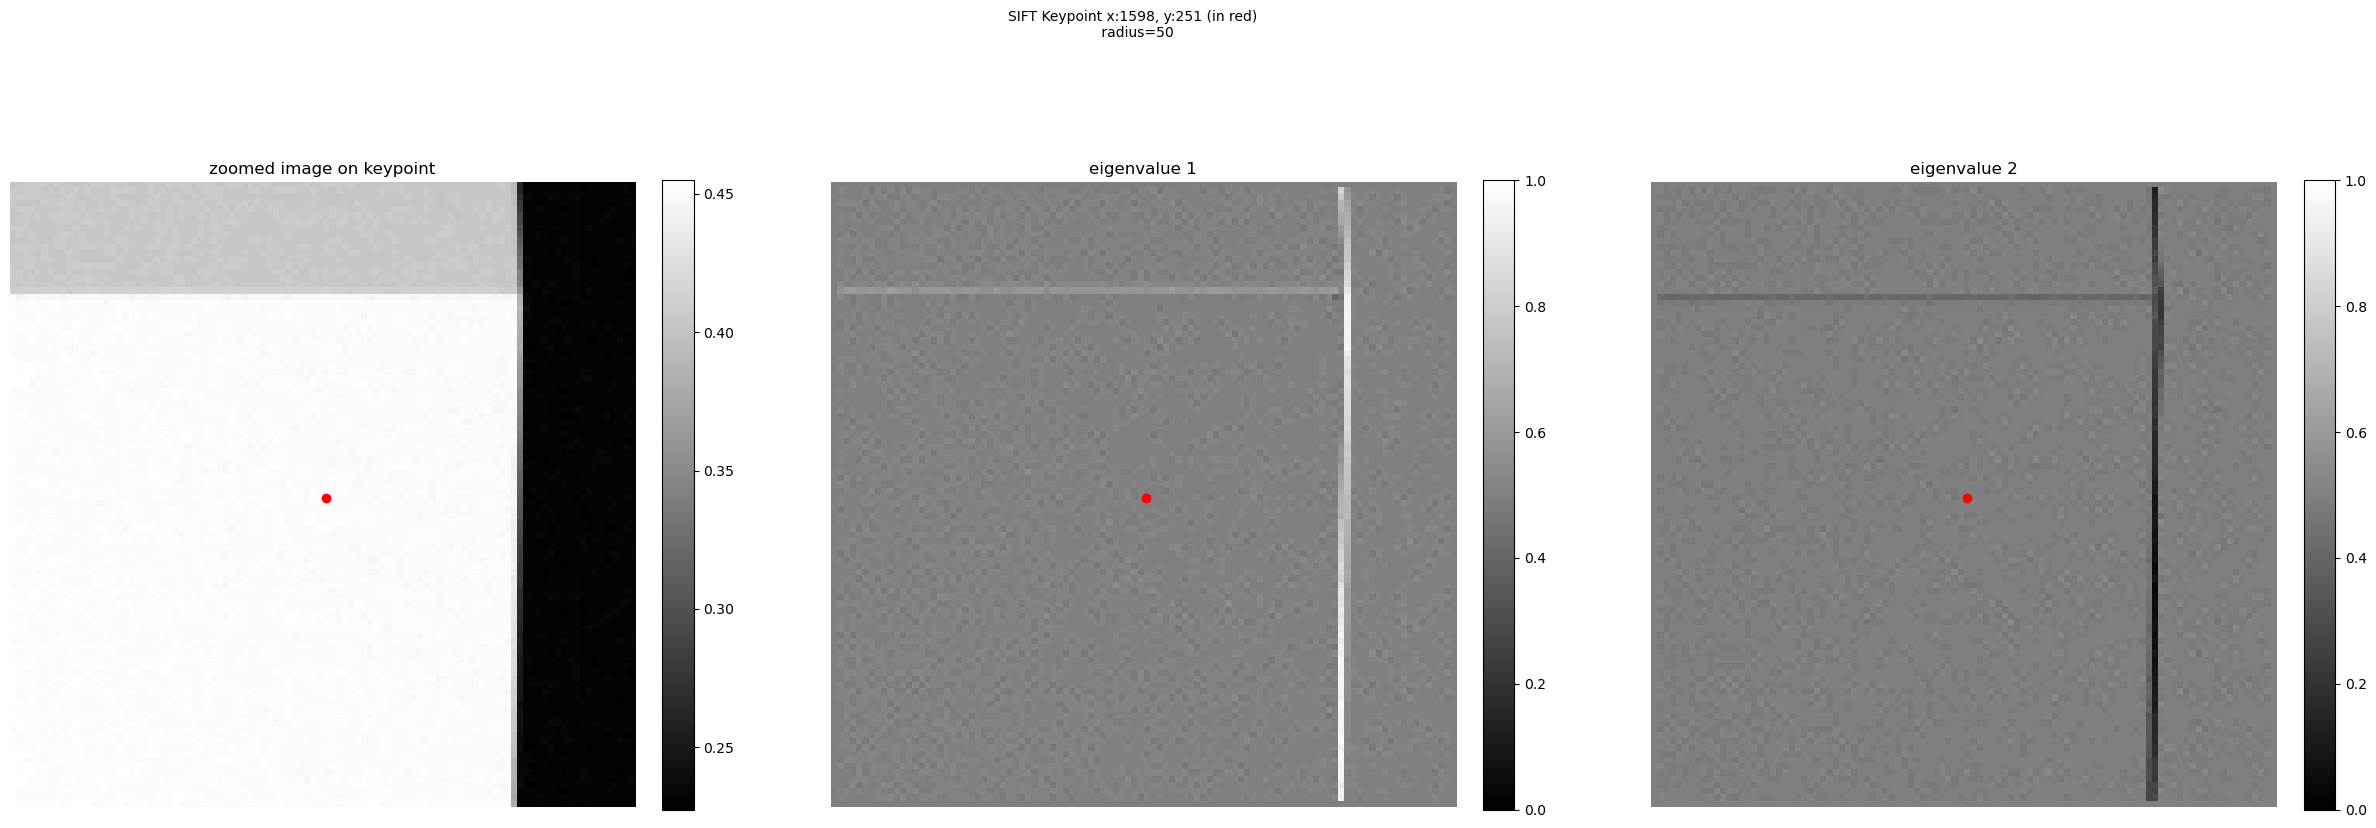

In [19]:
# display the figure of curvature values on the float versions
eigval_fig1 = vh.visualize_curvature_values(float_im1, kp1, zoom_radius)
plt.figure(eigval_fig1.number)
plt.show()

eigval_fig2 = vh.visualize_curvature_values(float_im2, kp2, zoom_radius)
plt.figure(eigval_fig2.number)
plt.show()

Display curvature directions side by side


In [20]:
dir_fig = vh.compare_directions(float_im1, float_im2, kp1, kp2, zoom_radius, dpi=800)

# show figure
plt.figure(dir_fig.number)
plt.show()

Show gradients side by side²


In [21]:
grad_fig = vh.compare_gradients(float_im1, float_im2, kp1, kp2, zoom_radius, dpi=800)

# show figure
plt.figure(grad_fig.number)
plt.show()

# Compute histograms descriptors of keypoints


In [22]:
kp_position1 = kp1.pt
# convert into integer
kp_position1 = np.round(kp_position1).astype(int)
kp_position1 = tuple(kp_position1)
kp_position1

(1596, 440)

In [23]:
# compute overall features of a subimage of first image
border_size = 1
feature_radius = zoom_radius + 20
cropped_im1 = vh.crop_image_around_keypoint(float_im1, kp_position1, feature_radius)
zoomed_features = desc.compute_features_overall(cropped_im1, border_size)

zoomed_kp_position1 = (feature_radius, feature_radius)

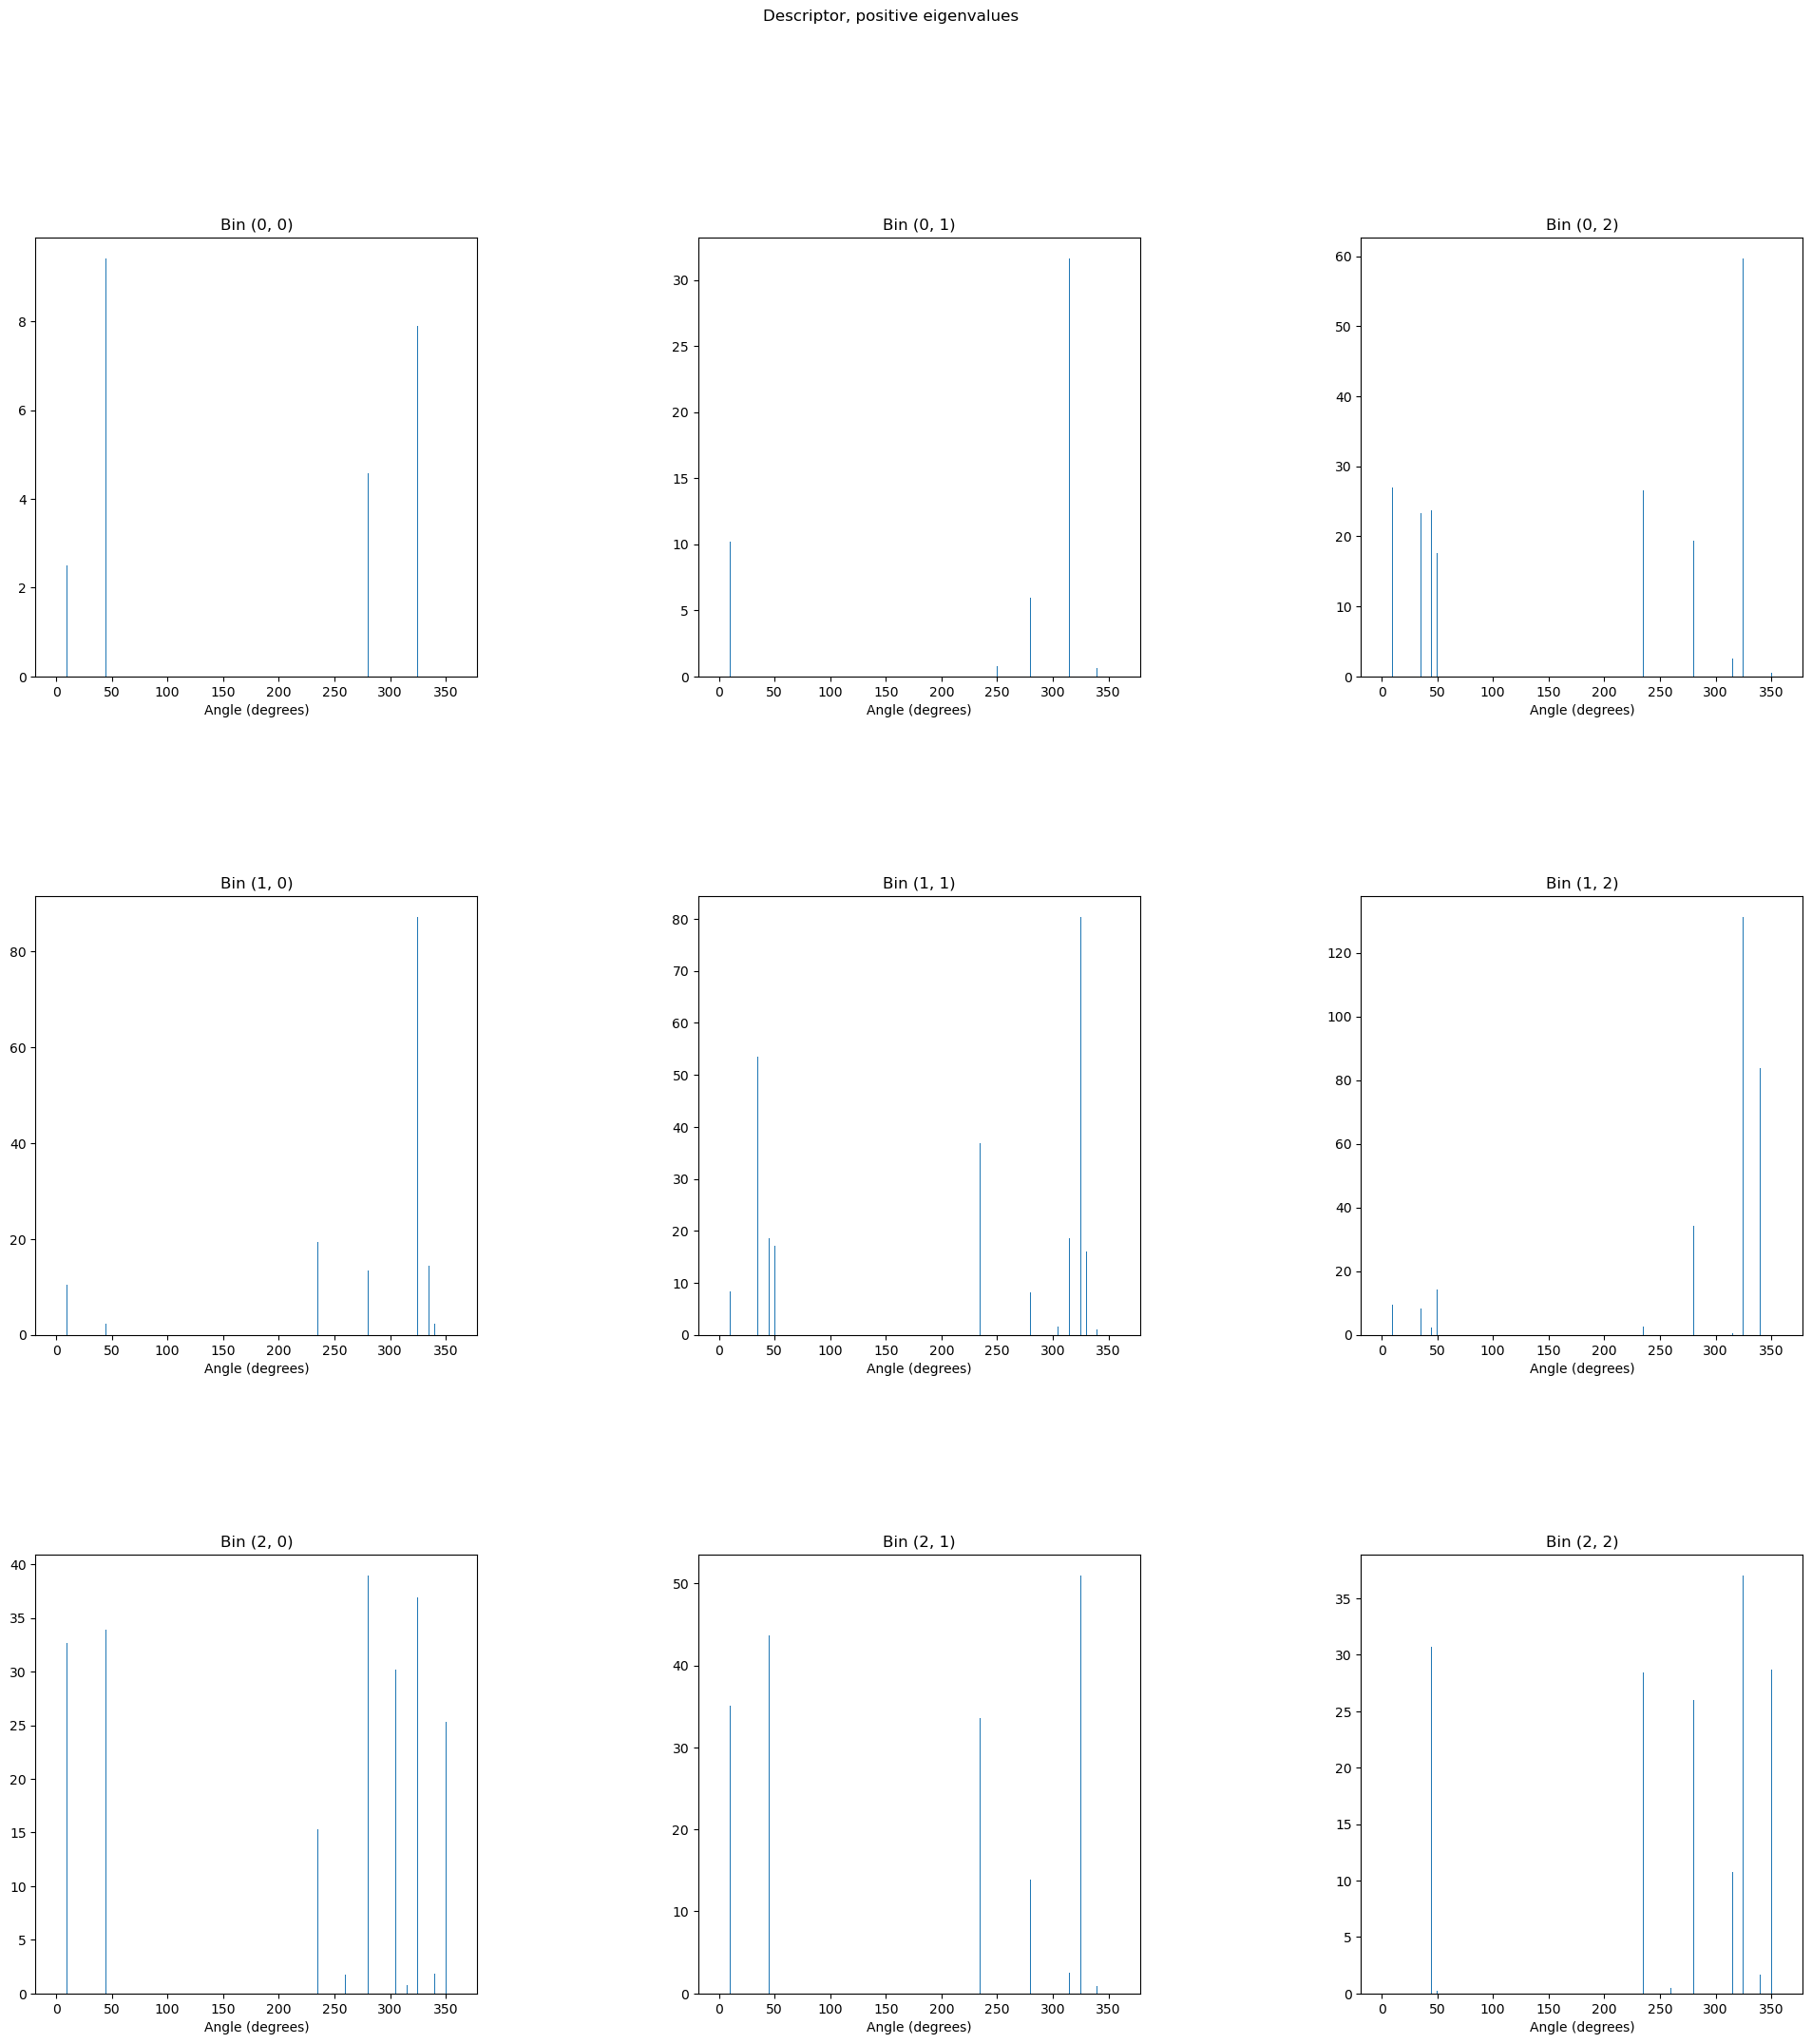

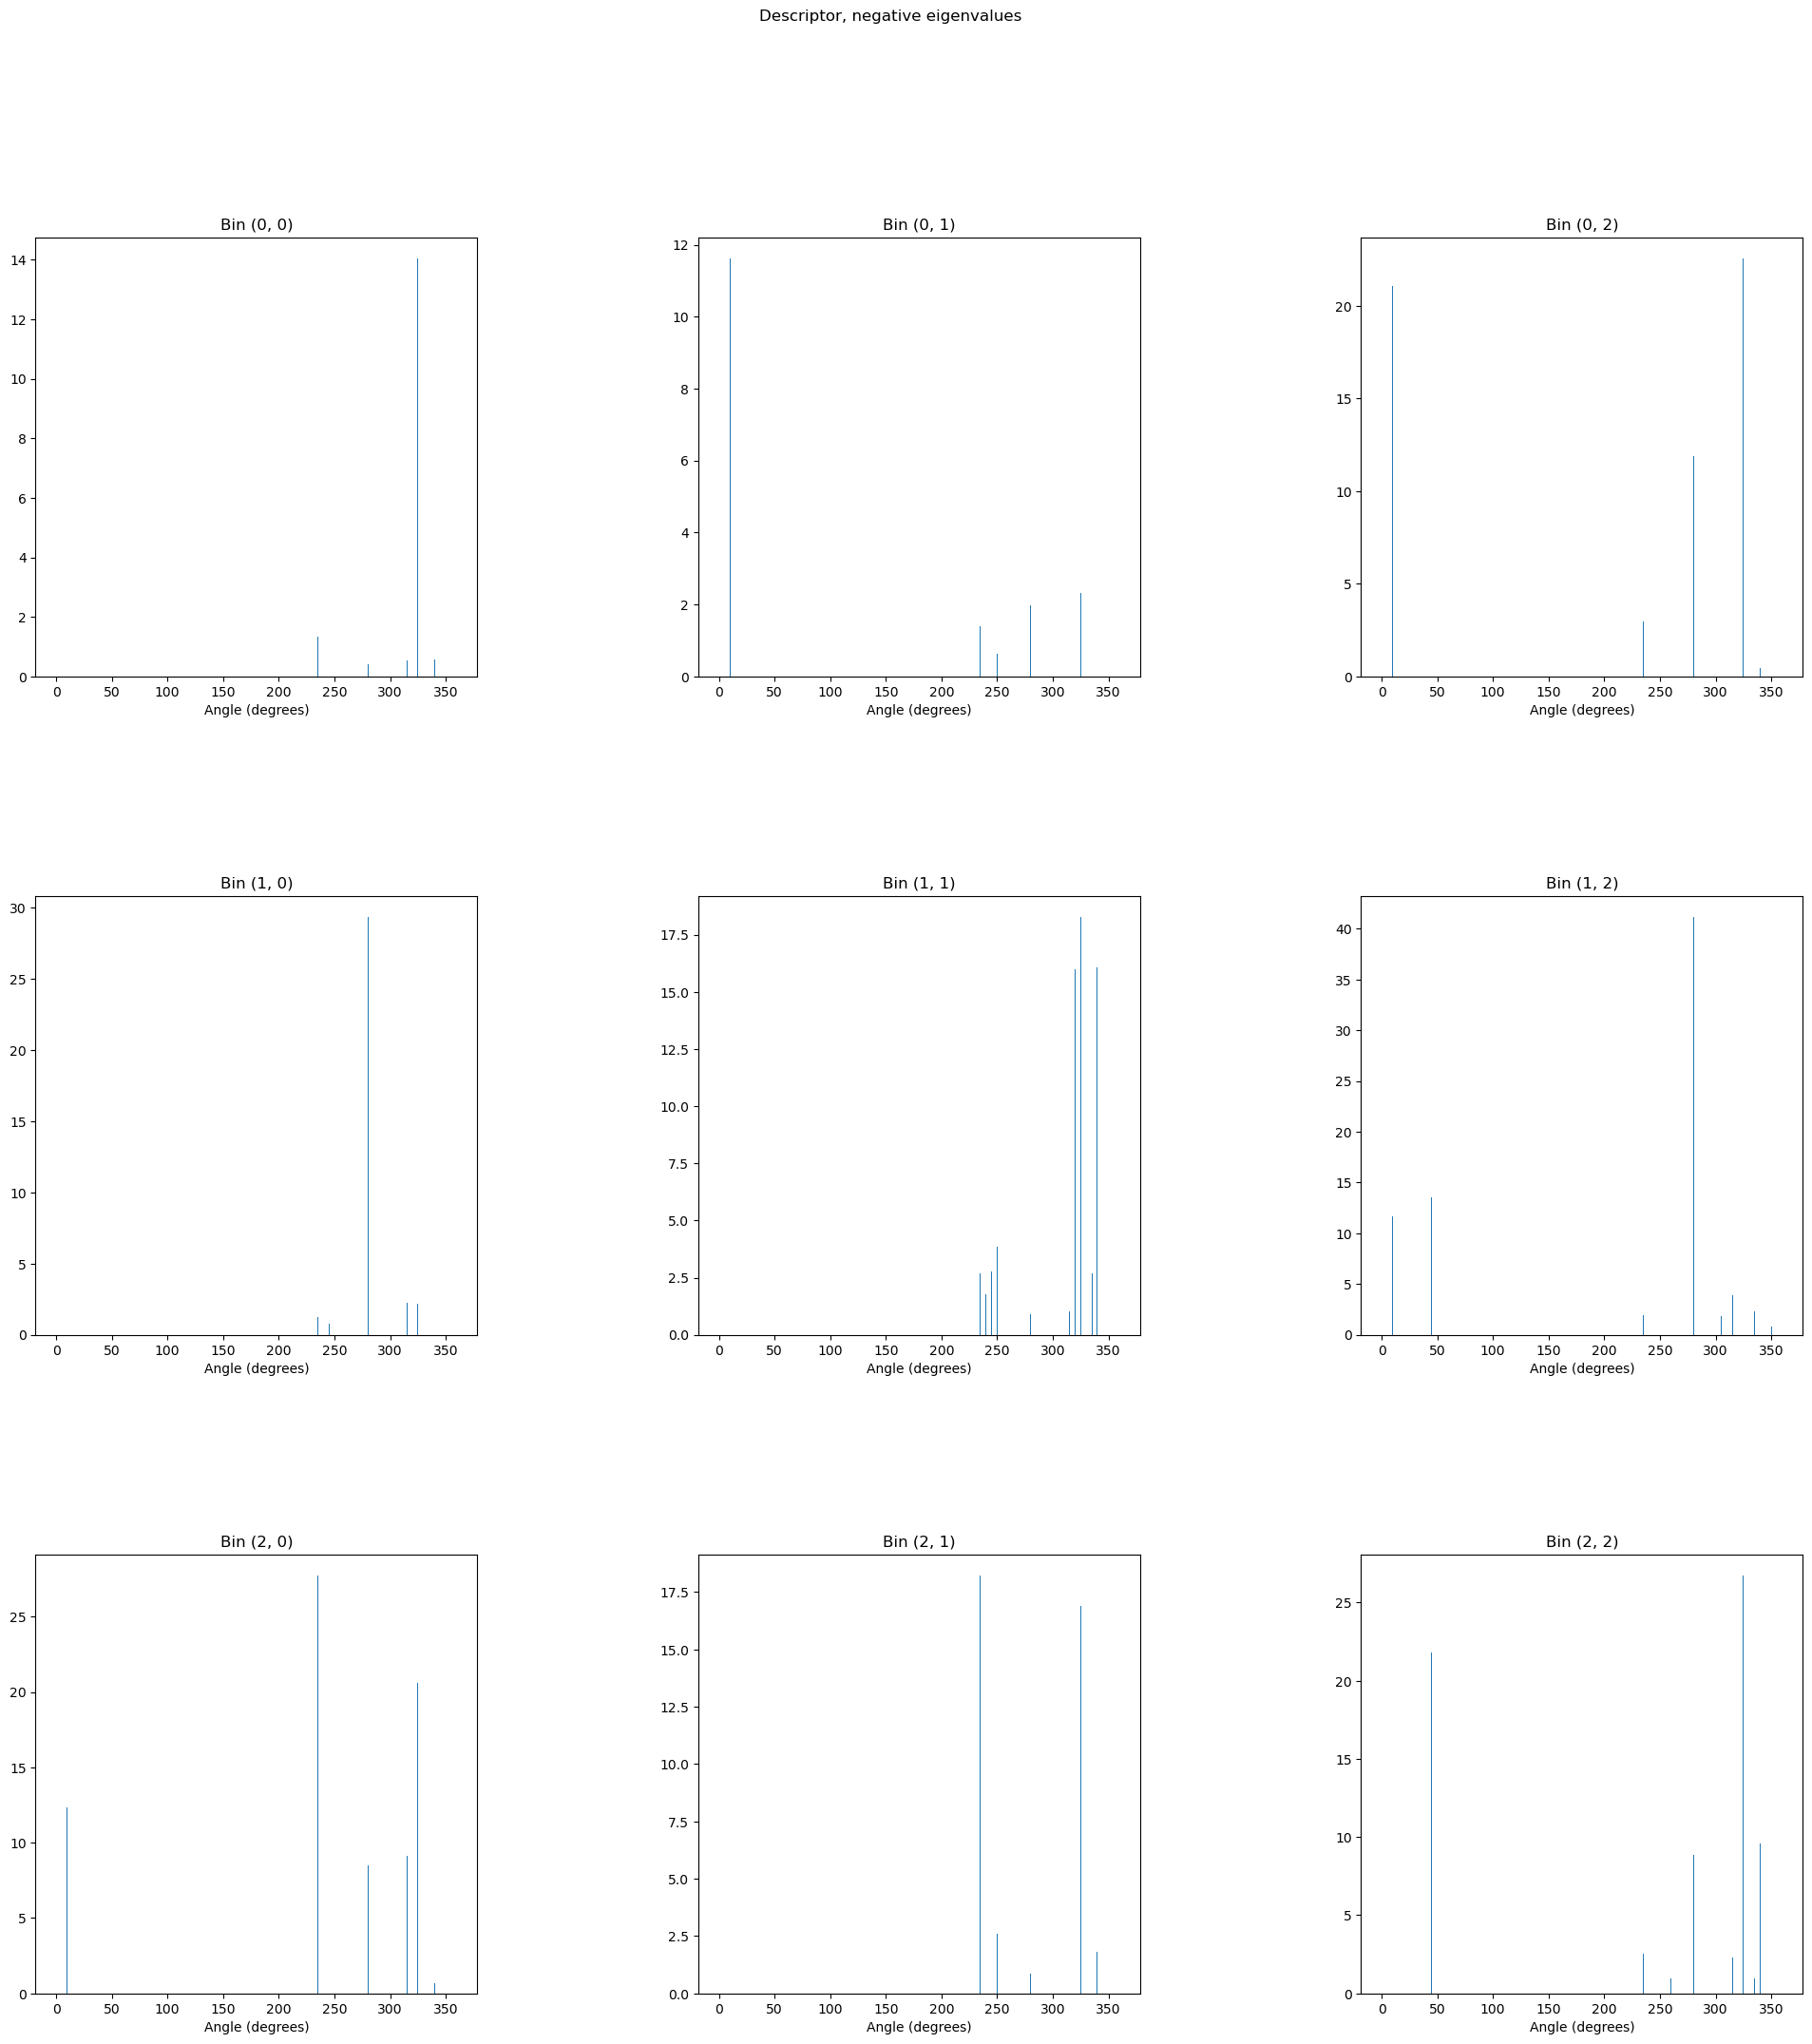

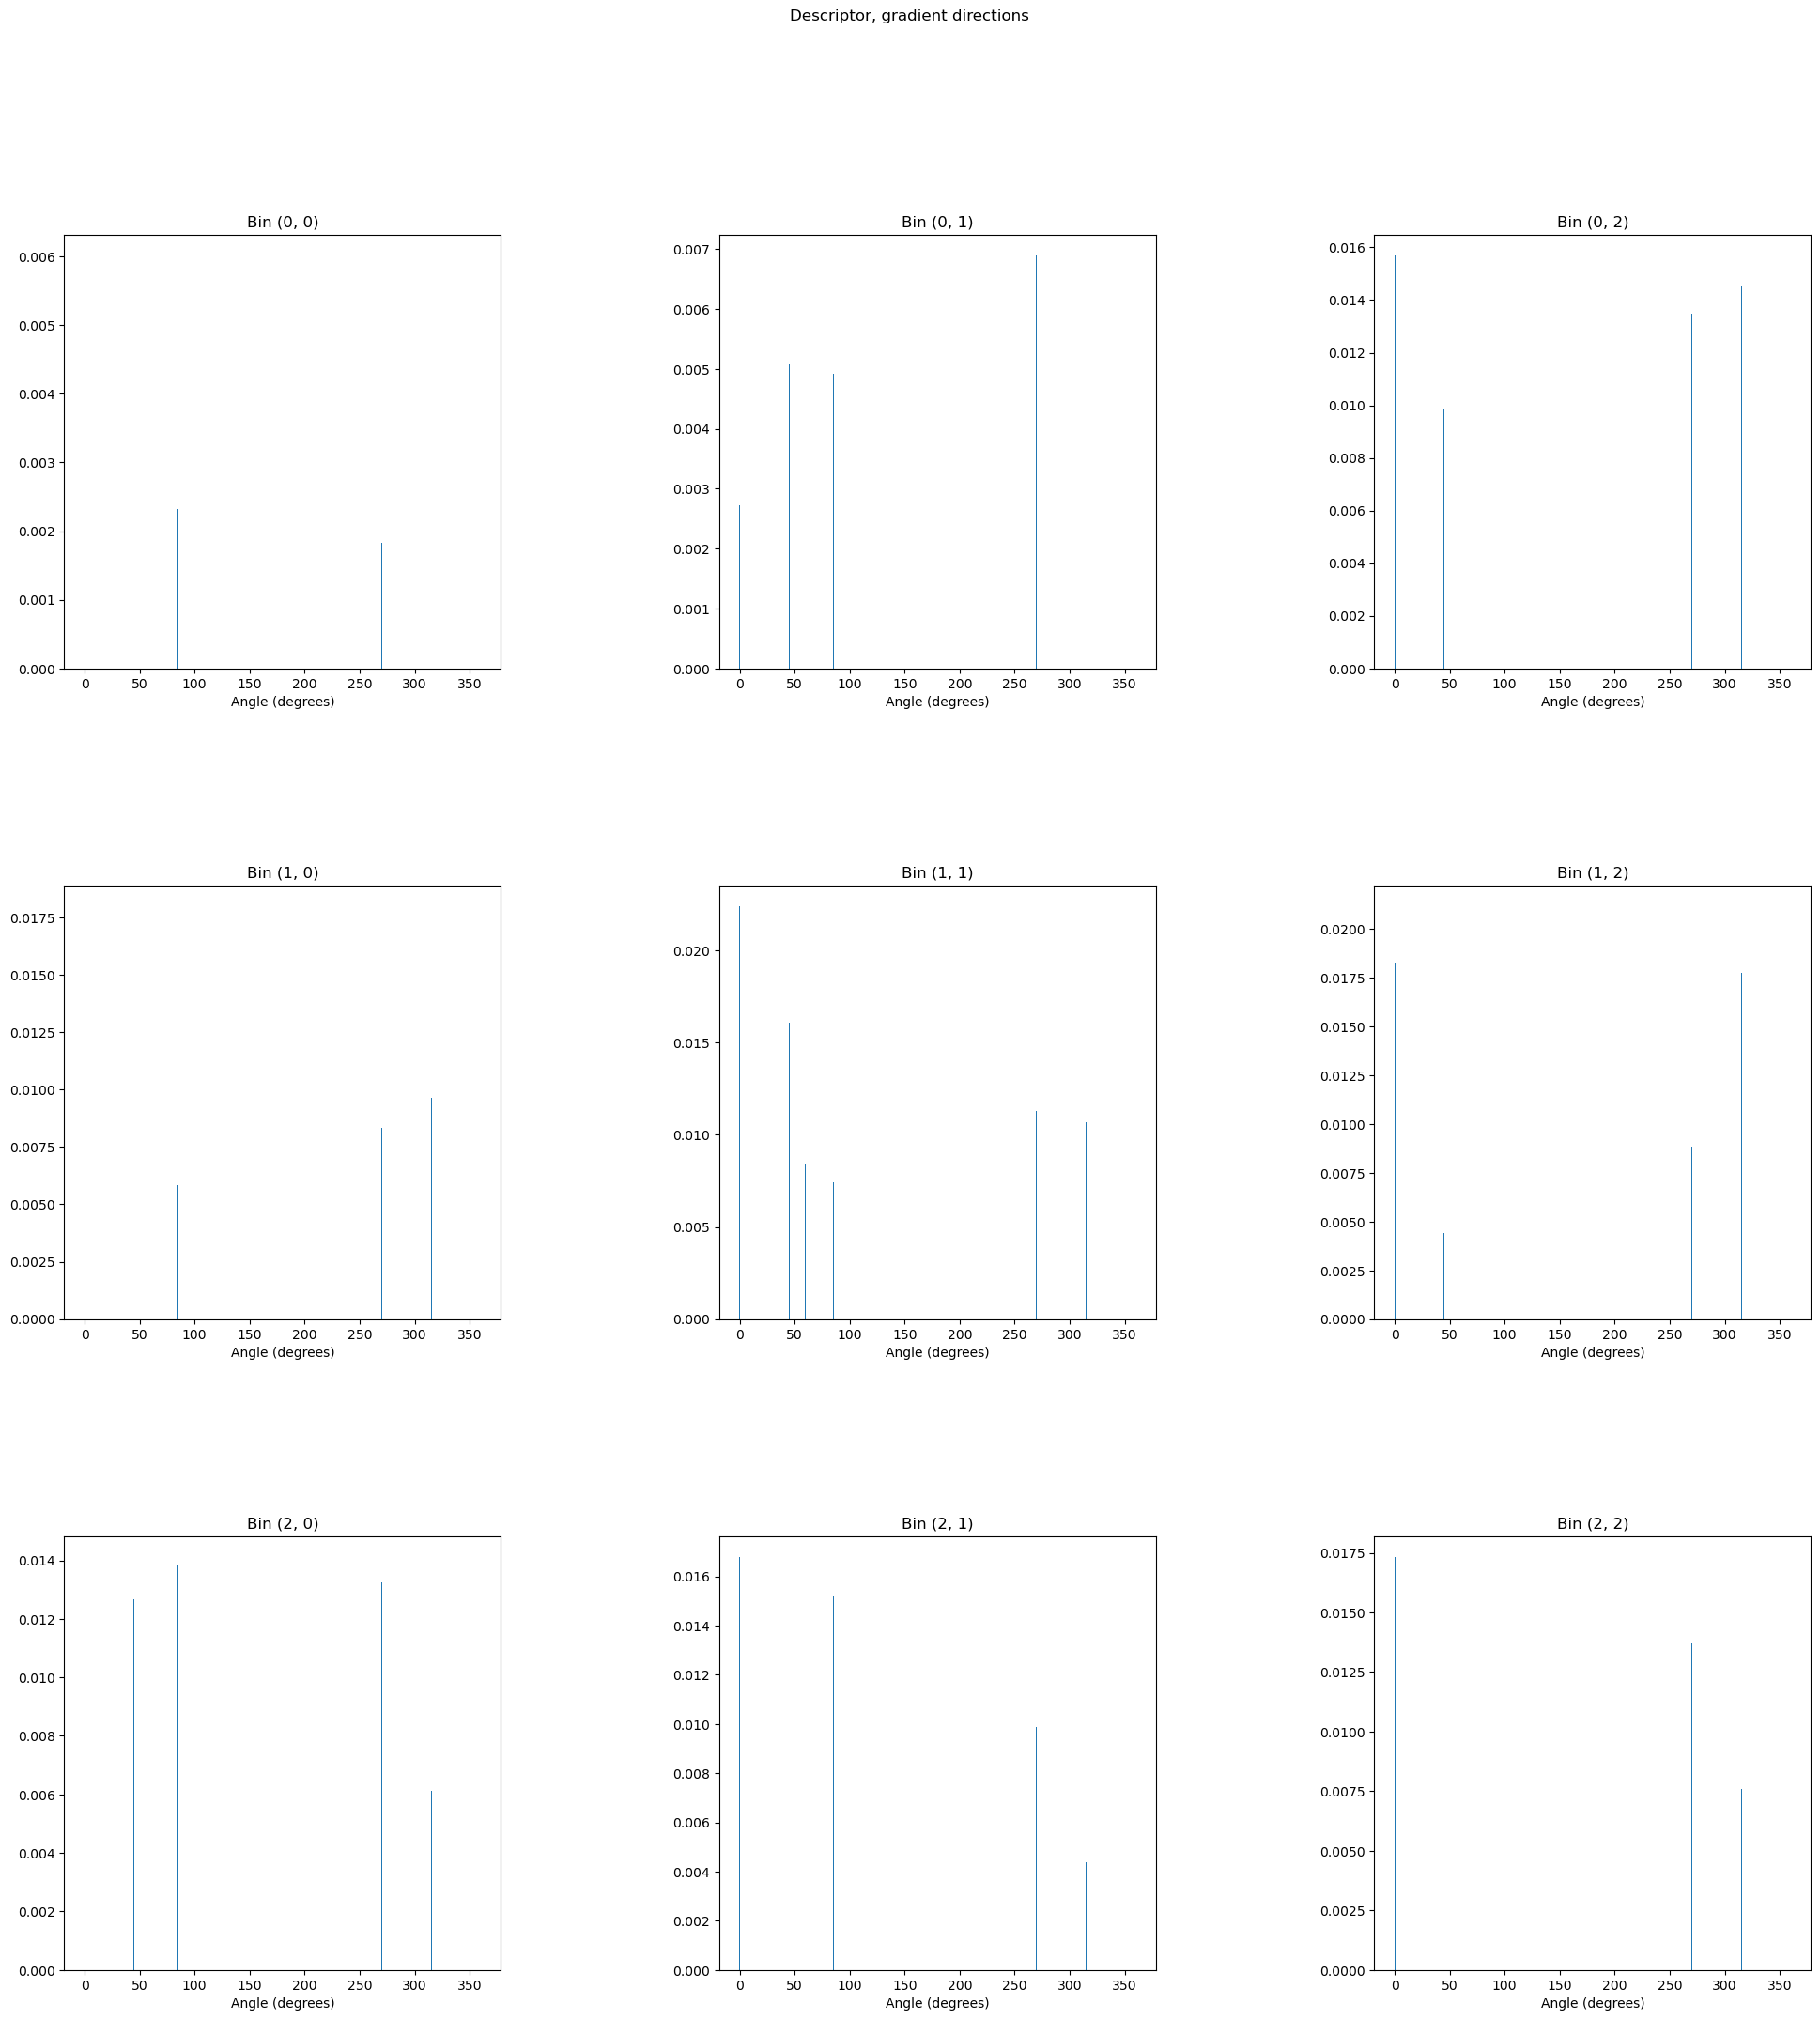

In [24]:
descriptor_histograms = desc.compute_descriptor_histograms(
    zoomed_features, zoomed_kp_position1
)

values_names = ["positive eigenvalues", "negative eigenvalues", "gradient directions"]
desc.display_descriptor(descriptor_histograms, values_names=values_names)